# Ad Optimization Agent

An intelligent agent that allocates daily advertising budgets across multiple channels to maximize conversions using LLM-powered reasoning and iterative learning.

## Key Features
- **Adaptive Budget Allocation**: Analyzes performance data and proposes optimal spend distribution
- **LLM Reasoning**: Uses Google Gemini to provide strategic, explainable decisions
- **Guardrails**: Enforces business constraints (15-60% per channel, ±25% daily shifts)
- **Iterative Learning**: Adapts strategy based on simulated outcomes over time
- **Baseline Comparison**: Evaluates against simple equal-split strategy

## Channels
- **Search**: Google Ads, Bing Ads (typically high-intent, stable performance)
- **Social**: Facebook, Instagram, LinkedIn (brand awareness, variable performance)
- **Display**: Banner ads, programmatic (reach-focused, typically lower conversion rates)

## 1. Setup & Dependencies

In [1]:
import os
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
from dotenv import load_dotenv
from google import genai

# Load environment variables
load_dotenv()
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY not found in environment variables. Please create a .env file.")

# Initialize Gemini client
client = genai.Client(api_key=GEMINI_API_KEY)

print("✓ Dependencies loaded")
print("✓ Gemini client initialized")

✓ Dependencies loaded
✓ Gemini client initialized


## 2. Configuration

In [2]:
CONFIG = {
    # Budget parameters
    'daily_budget': 1000.0,  # Fixed daily budget in dollars
    
    # Allocation constraints
    'min_allocation': 0.15,  # 15% minimum per channel
    'max_allocation': 0.60,  # 60% maximum per channel
    'max_daily_shift': 0.25,  # ±25% maximum daily change
    
    # Analysis parameters
    'lookback_days': 7,  # Analyze last 7 days for decisions
    'train_days': 14,  # Days 1-14 for building performance model
    'test_start_day': 15,  # Start optimization from day 15
    
    # LLM configuration
    'model': 'gemini-2.0-flash-lite',
    'temperature': 0.3,  # Lower temperature for more consistent decisions
    'max_tokens': 800,
    
    # Channels
    'channels': ['Search', 'Social', 'Display'],
    
    # Rate limiting
    'api_delay': 2.0,  # Seconds between API calls (respect 30 RPM limit)
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  daily_budget: 1000.0
  min_allocation: 0.15
  max_allocation: 0.6
  max_daily_shift: 0.25
  lookback_days: 7
  train_days: 14
  test_start_day: 15
  model: gemini-2.0-flash-lite
  temperature: 0.3
  max_tokens: 800
  channels: ['Search', 'Social', 'Display']
  api_delay: 2.0


## 3. Load Data

In [3]:
# Load ad performance data
df = pd.read_csv('ad_performance_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

print(f"✓ Loaded {len(df)} rows of data")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Channels: {df['channel'].unique().tolist()}")
print(f"\nFirst 5 rows:")
df.head()

✓ Loaded 90 rows of data
  Date range: 2024-10-01 00:00:00 to 2024-10-30 00:00:00
  Channels: ['Search', 'Social', 'Display']

First 5 rows:


,date,channel,spend,impressions,clicks,conversions
0,2024-10-01,Search,422.31,37555,1449,33
1,2024-10-01,Social,383.11,31980,1218,26
2,2024-10-01,Display,242.19,24271,492,6
3,2024-10-02,Search,324.25,33007,1351,35
4,2024-10-02,Social,310.86,24949,912,19


In [4]:
# Quick data validation
print("Data Summary by Channel:")
summary = df.groupby('channel').agg({
    'spend': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum'
})
summary['CTR'] = (summary['clicks'] / summary['impressions'] * 100).round(2)
summary['CVR'] = (summary['conversions'] / summary['clicks'] * 100).round(2)
summary['CPA'] = (summary['spend'] / summary['conversions']).round(2)
summary

Data Summary by Channel:


,spend,impressions,clicks,conversions,CTR,CVR,CPA
channel,,,,,,,
Display,7643.04,758601,19091,207,2.52,1.08,36.92
Search,12079.26,1220068,55085,1392,4.51,2.53,8.68
Social,10391.40,1025363,35025,758,3.42,2.16,13.71


## 4. Helper Functions

These functions handle performance analysis, validation, and simulation.

In [5]:
def calculate_performance_metrics(df: pd.DataFrame, start_day: int, end_day: int, channels: List[str]) -> Dict:
    """
    Calculate performance metrics for each channel over a date range.
    
    Returns:
        Dictionary with channel-level metrics:
        - ctr: Click-through rate
        - cvr: Conversion rate
        - cpm: Cost per thousand impressions
        - cpa: Cost per acquisition
        - trend: Daily CVR trend slope
        - volatility: Standard deviation of daily CVR
    """
    metrics = {}
    
    # Filter to date range
    start_date = df['date'].min() + timedelta(days=start_day - 1)
    end_date = df['date'].min() + timedelta(days=end_day - 1)
    df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    
    for channel in channels:
        channel_data = df_filtered[df_filtered['channel'] == channel]
        
        if len(channel_data) == 0:
            continue
        
        total_spend = channel_data['spend'].sum()
        total_impressions = channel_data['impressions'].sum()
        total_clicks = channel_data['clicks'].sum()
        total_conversions = channel_data['conversions'].sum()
        
        # Calculate rates
        ctr = total_clicks / total_impressions if total_impressions > 0 else 0
        cvr = total_conversions / total_clicks if total_clicks > 0 else 0
        cpm = (total_spend / total_impressions * 1000) if total_impressions > 0 else 0
        cpa = total_spend / total_conversions if total_conversions > 0 else float('inf')
        
        # Calculate daily CVR for trend analysis
        daily_cvr = []
        for _, day_data in channel_data.iterrows():
            day_cvr = day_data['conversions'] / day_data['clicks'] if day_data['clicks'] > 0 else 0
            daily_cvr.append(day_cvr)
        
        # Trend: linear regression slope
        if len(daily_cvr) > 1:
            x = np.arange(len(daily_cvr))
            z = np.polyfit(x, daily_cvr, 1)
            trend = z[0]  # Slope
            volatility = np.std(daily_cvr)
        else:
            trend = 0
            volatility = 0
        
        metrics[channel] = {
            'ctr': ctr,
            'cvr': cvr,
            'cpm': cpm,
            'cpa': cpa,
            'trend': trend,
            'volatility': volatility,
            'total_conversions': total_conversions,
            'total_spend': total_spend
        }
    
    return metrics

print("✓ calculate_performance_metrics defined")

✓ calculate_performance_metrics defined


In [6]:
def validate_allocation(proposed: Dict[str, float], 
                       previous: Optional[Dict[str, float]], 
                       config: Dict) -> Tuple[bool, Dict[str, float], List[str]]:
    """
    Validate and correct proposed allocation against constraints.
    
    Returns:
        (is_valid, corrected_allocation, violations_log)
    """
    violations = []
    corrected = proposed.copy()
    
    # Check 1: Sum to budget
    total = sum(corrected.values())
    if abs(total - config['daily_budget']) > 0.01:
        scale = config['daily_budget'] / total
        corrected = {ch: amt * scale for ch, amt in corrected.items()}
        violations.append(f"Total was ${total:.2f}, normalized to ${config['daily_budget']:.2f}")
    
    # Check 2: Min/max bounds per channel
    for channel, amount in list(corrected.items()):
        pct = amount / config['daily_budget']
        if pct < config['min_allocation']:
            corrected[channel] = config['daily_budget'] * config['min_allocation']
            violations.append(f"{channel} below {config['min_allocation']*100}% minimum, raised")
        elif pct > config['max_allocation']:
            corrected[channel] = config['daily_budget'] * config['max_allocation']
            violations.append(f"{channel} above {config['max_allocation']*100}% maximum, capped")
    
    # Re-normalize after bounds correction
    total = sum(corrected.values())
    if abs(total - config['daily_budget']) > 0.01:
        scale = config['daily_budget'] / total
        corrected = {ch: amt * scale for ch, amt in corrected.items()}
    
    # Check 3: Daily shift limit (if previous exists)
    if previous:
        for channel in corrected:
            prev_amt = previous.get(channel, config['daily_budget'] / len(corrected))
            max_shift = prev_amt * config['max_daily_shift']
            
            if corrected[channel] > prev_amt + max_shift:
                corrected[channel] = prev_amt + max_shift
                violations.append(f"{channel} +{config['max_daily_shift']*100}% shift limit exceeded, capped")
            elif corrected[channel] < prev_amt - max_shift:
                corrected[channel] = prev_amt - max_shift
                violations.append(f"{channel} -{config['max_daily_shift']*100}% shift limit exceeded, capped")
        
        # Re-normalize after shift correction
        total = sum(corrected.values())
        if abs(total - config['daily_budget']) > 0.01:
            scale = config['daily_budget'] / total
            corrected = {ch: amt * scale for ch, amt in corrected.items()}
    
    is_valid = len(violations) == 0
    return is_valid, corrected, violations

print("✓ validate_allocation defined")

✓ validate_allocation defined


In [7]:
def simulate_conversions(allocation: Dict[str, float], 
                        performance_model: Dict,
                        day_number: int,
                        add_noise: bool = True) -> Dict[str, int]:
    """
    Simulate expected conversions based on allocation and performance model.
    
    This models what would happen if we allocated budgets as proposed.
    
    Args:
        allocation: Dict mapping channel to budget amount
        performance_model: Dict with channel performance metrics
        day_number: Current day (for trend adjustment)
        add_noise: Whether to add realistic variance
    
    Returns:
        Dict mapping channel to simulated conversions
    """
    results = {}
    
    for channel, budget in allocation.items():
        perf = performance_model[channel]
        
        # Step 1: Estimate impressions based on CPM
        impressions = (budget / perf['cpm']) * 1000 if perf['cpm'] > 0 else 0
        
        # Step 2: Estimate clicks based on CTR
        clicks = impressions * perf['ctr']
        
        # Step 3: Estimate conversions based on CVR + trend
        # Trend is already calculated from training period
        adjusted_cvr = perf['cvr'] + (perf['trend'] * day_number)
        adjusted_cvr = max(0.005, min(0.05, adjusted_cvr))  # Clamp to realistic range
        
        conversions = clicks * adjusted_cvr
        
        # Step 4: Add realistic noise if requested
        if add_noise and perf['volatility'] > 0:
            noise = np.random.normal(0, perf['volatility'])
            conversions = conversions * (1 + noise)
        
        results[channel] = max(0, int(conversions))
    
    return results

print("✓ simulate_conversions defined")

✓ simulate_conversions defined


## 5. Build Performance Model

Train the performance model on days 1-14 to understand each channel's characteristics.

In [8]:
# Build performance model from training period (days 1-14)
performance_model = calculate_performance_metrics(
    df, 
    start_day=1, 
    end_day=CONFIG['train_days'], 
    channels=CONFIG['channels']
)

print("Performance Model (Days 1-14):")
print("\n{:<10} {:>8} {:>8} {:>10} {:>10} {:>10}".format(
    'Channel', 'CTR', 'CVR', 'CPA', 'Trend', 'Volatility'
))
print("-" * 66)
for channel, metrics in performance_model.items():
    print("{:<10} {:>7.2f}% {:>7.2f}% ${:>9.2f} {:>9.4f} {:>10.4f}".format(
        channel,
        metrics['ctr'] * 100,
        metrics['cvr'] * 100,
        metrics['cpa'],
        metrics['trend'],
        metrics['volatility']
    ))

Performance Model (Days 1-14):

Channel         CTR      CVR        CPA      Trend Volatility
------------------------------------------------------------------
Search        4.46%    2.54% $     8.97    0.0000     0.0023
Social        3.49%    1.97% $    14.79    0.0001     0.0032
Display       2.48%    1.18% $    34.90   -0.0002     0.0013


## 6. System Prompt Template

This prompt guides the LLM to make strategic allocation decisions.

In [9]:
def build_system_prompt(recent_metrics: Dict, 
                        previous_allocation: Optional[Dict[str, float]],
                        config: Dict) -> str:
    """
    Build the system prompt for the LLM with current data and constraints.
    """
    
    # Format metrics table
    metrics_lines = []
    for channel, metrics in recent_metrics.items():
        metrics_lines.append(f"  {channel}:")
        metrics_lines.append(f"    - CPA: ${metrics['cpa']:.2f}")
        metrics_lines.append(f"    - CVR: {metrics['cvr']*100:.2f}%")
        metrics_lines.append(f"    - CTR: {metrics['ctr']*100:.2f}%")
        trend_label = '↑ improving' if metrics['trend'] > 0.0001 else '↓ declining' if metrics['trend'] < -0.0001 else '→ stable'
        metrics_lines.append(f"    - Trend: {trend_label}")
        metrics_lines.append(f"    - Recent conversions: {metrics['total_conversions']}")
        metrics_lines.append(f"    - Recent spend: ${metrics['total_spend']:.2f}")
    
    metrics_table = "\n".join(metrics_lines)
    
    # Format previous allocation
    if previous_allocation:
        prev_str = "\n".join([
            f"    - {channel}: ${amount:.2f} ({amount/config['daily_budget']*100:.1f}%)"
            for channel, amount in previous_allocation.items()
        ])
    else:
        prev_str = "    None (first optimization run - no shift limits apply)"
    
    prompt = f"""You are an expert digital marketing strategist specializing in performance advertising optimization. Your role is to analyze multi-channel ad campaign data and recommend optimal daily budget allocations.

OBJECTIVE: Maximize total conversions within a fixed daily budget of ${config['daily_budget']:.2f}.

AVAILABLE CHANNELS: {', '.join(config['channels'])}

PERFORMANCE DATA (Last {config['lookback_days']} days):
{metrics_table}

CONSTRAINTS:
1. Each channel must receive between {config['min_allocation']*100:.0f}% and {config['max_allocation']*100:.0f}% of total budget
2. Allocations must sum to exactly ${config['daily_budget']:.2f}
3. Daily allocation shifts are limited to ±{config['max_daily_shift']*100:.0f}% from previous day (except first run)
4. Previous allocation:
{prev_str}

DECISION FRAMEWORK:
- Prioritize channels with lowest CPA (most cost-effective)
- Consider trends: reward improving channels, reduce declining channels
- Balance proven performance (stable, low CPA) vs emerging opportunities (improving trends)
- Maintain diversification across all channels (min 15% rule)
- Explain trade-offs clearly

OUTPUT FORMAT (valid JSON only):
{{
  "allocations": {{
    "Search": <dollar_amount>,
    "Social": <dollar_amount>,
    "Display": <dollar_amount>
  }},
  "reasoning": "<2-3 sentences explaining your decision, referencing specific data points and trade-offs>",
  "expected_conversions": {{
    "Search": <estimated_integer>,
    "Social": <estimated_integer>,
    "Display": <estimated_integer>
  }},
  "confidence": "<Low|Medium|High>"
}}

EXAMPLE (illustrative only, use actual data above):
{{
  "allocations": {{
    "Search": 500.00,
    "Social": 350.00,
    "Display": 150.00
  }},
  "reasoning": "Search has the lowest CPA at $8.50 and stable performance, so allocated 50%. Social shows improving trend (+0.3% CVR) despite higher CPA, warranting 35% to capitalize on momentum. Display has highest CPA at $35 and declining trend, minimized to 15% to maintain presence.",
  "expected_conversions": {{
    "Search": 58,
    "Social": 26,
    "Display": 4
  }},
  "confidence": "High"
}}

Now analyze the data above and propose the optimal allocation for tomorrow. Return ONLY valid JSON.
"""
    
    return prompt

print("✓ build_system_prompt defined")

✓ build_system_prompt defined


## 7. Ad Optimization Agent Class

Main agent that uses LLM reasoning to propose allocations.

In [10]:
class AdOptimizationAgent:
    """
    Intelligent agent that uses LLM reasoning to optimize ad budget allocation.
    """
    
    def __init__(self, config: Dict, historical_data: pd.DataFrame, performance_model: Dict):
        self.config = config
        self.df = historical_data
        self.performance_model = performance_model
        self.client = genai.Client(api_key=GEMINI_API_KEY)
        
        # Decision history
        self.decisions = []
        self.allocations_history = []
        
        # Stats tracking
        self.total_api_calls = 0
        self.total_tokens = 0
        self.total_conversions = 0
        self.total_spend = 0
    
    def _get_recent_metrics(self, current_day: int) -> Dict:
        """
        Get performance metrics for the lookback window.
        """
        lookback_start = max(1, current_day - self.config['lookback_days'])
        return calculate_performance_metrics(
            self.df,
            start_day=lookback_start,
            end_day=current_day - 1,  # Up to yesterday
            channels=self.config['channels']
        )
    
    def propose_allocation(self, current_day: int, previous_allocation: Optional[Dict[str, float]] = None) -> Dict:
        """
        Propose budget allocation for the given day using LLM reasoning.
        
        Returns:
            Dictionary with allocation, reasoning, expected conversions, metadata
        """
        # Get recent performance data
        recent_metrics = self._get_recent_metrics(current_day)
        
        # Build prompt
        prompt = build_system_prompt(recent_metrics, previous_allocation, self.config)
        
        # Call LLM
        try:
            response = self.client.models.generate_content(
                model=self.config['model'],
                contents=prompt,
                config=genai.types.GenerateContentConfig(
                    max_output_tokens=self.config['max_tokens'],
                    temperature=self.config['temperature'],
                )
            )
            
            # Parse response
            response_text = response.text.strip()
            
            # Extract JSON (handle markdown code blocks)
            if '```json' in response_text:
                response_text = response_text.split('```json')[1].split('```')[0].strip()
            elif '```' in response_text:
                response_text = response_text.split('```')[1].split('```')[0].strip()
            
            llm_output = json.loads(response_text)
            
            # Extract allocations
            proposed_allocation = llm_output['allocations']
            
            # Validate and correct if needed
            is_valid, corrected_allocation, violations = validate_allocation(
                proposed_allocation, previous_allocation, self.config
            )
            
            # Track stats
            self.total_api_calls += 1
            self.total_tokens += response.usage_metadata.total_token_count
            
            # Wait to respect rate limits
            time.sleep(self.config['api_delay'])
            
            # Build decision record
            decision = {
                'day': current_day,
                'timestamp': datetime.now().isoformat(),
                'proposed_allocation': proposed_allocation,
                'final_allocation': corrected_allocation,
                'was_valid': is_valid,
                'violations': violations,
                'reasoning': llm_output.get('reasoning', 'No reasoning provided'),
                'expected_conversions': llm_output.get('expected_conversions', {}),
                'confidence': llm_output.get('confidence', 'Unknown'),
                'tokens_used': response.usage_metadata.total_token_count,
                'recent_metrics': recent_metrics
            }
            
            self.decisions.append(decision)
            self.allocations_history.append(corrected_allocation)
            
            return decision
            
        except Exception as e:
            print(f"Error in LLM call: {e}")
            # Fallback: equal allocation or previous allocation
            fallback = previous_allocation if previous_allocation else {
                ch: self.config['daily_budget'] / len(self.config['channels']) 
                for ch in self.config['channels']
            }
            return {
                'day': current_day,
                'final_allocation': fallback,
                'error': str(e),
                'reasoning': 'Error occurred, using fallback allocation'
            }
    
    def record_outcome(self, day: int, actual_conversions: Dict[str, int]):
        """
        Record the actual conversions that resulted from an allocation.
        This updates the agent's context for future decisions.
        """
        # Find the decision for this day
        for decision in self.decisions:
            if decision['day'] == day:
                decision['actual_conversions'] = actual_conversions
                decision['total_conversions'] = sum(actual_conversions.values())
                
                # Update stats
                self.total_conversions += decision['total_conversions']
                self.total_spend += self.config['daily_budget']
                break
    
    def get_stats(self) -> Dict:
        """
        Get comprehensive statistics about agent performance.
        """
        return {
            'total_decisions': len(self.decisions),
            'total_api_calls': self.total_api_calls,
            'total_tokens': self.total_tokens,
            'total_conversions': self.total_conversions,
            'total_spend': self.total_spend,
            'average_cpa': self.total_spend / self.total_conversions if self.total_conversions > 0 else 0,
            'decisions': self.decisions,
            'allocations_history': self.allocations_history
        }

print("✓ AdOptimizationAgent class defined")

✓ AdOptimizationAgent class defined


## 8. Baseline Agent Class

Simple baseline strategy for comparison: equal budget split.

In [11]:
class BaselineAgent:
    """
    Simple baseline agent that allocates budget equally across all channels.
    No LLM, no optimization - just a fair benchmark.
    """
    
    def __init__(self, config: Dict):
        self.config = config
        self.equal_allocation = {
            channel: config['daily_budget'] / len(config['channels'])
            for channel in config['channels']
        }
        
        # Stats tracking
        self.total_conversions = 0
        self.total_spend = 0
        self.daily_conversions = []
    
    def propose_allocation(self, current_day: int, previous_allocation: Optional[Dict[str, float]] = None) -> Dict:
        """
        Always return equal allocation - no optimization.
        """
        return {
            'day': current_day,
            'final_allocation': self.equal_allocation.copy(),
            'reasoning': 'Equal split: 33.3% per channel (baseline strategy)'
        }
    
    def record_outcome(self, day: int, actual_conversions: Dict[str, int]):
        """
        Record conversions for tracking.
        """
        total = sum(actual_conversions.values())
        self.total_conversions += total
        self.total_spend += self.config['daily_budget']
        self.daily_conversions.append(total)
    
    def get_stats(self) -> Dict:
        """
        Get statistics.
        """
        return {
            'total_conversions': self.total_conversions,
            'total_spend': self.total_spend,
            'average_cpa': self.total_spend / self.total_conversions if self.total_conversions > 0 else 0,
            'daily_conversions': self.daily_conversions
        }

print("✓ BaselineAgent class defined")

✓ BaselineAgent class defined


## 9. Demonstration: Single Day Optimization

Let's see the agent make one decision for Day 15.

In [12]:
# Initialize agent
agent = AdOptimizationAgent(CONFIG, df, performance_model)

# Get allocation for Day 15 (first optimization day)
print("=" * 80)
print("DAY 15 OPTIMIZATION DECISION")
print("=" * 80)

decision_day15 = agent.propose_allocation(current_day=15, previous_allocation=None)

print(f"\nProposed Allocation:")
for channel, amount in decision_day15['final_allocation'].items():
    pct = (amount / CONFIG['daily_budget']) * 100
    print(f"  {channel}: ${amount:.2f} ({pct:.1f}%)")

print(f"\nReasoning:")
print(f"  {decision_day15['reasoning']}")

print(f"\nExpected Conversions:")
for channel, conv in decision_day15.get('expected_conversions', {}).items():
    print(f"  {channel}: {conv}")

print(f"\nConfidence: {decision_day15.get('confidence', 'N/A')}")

if not decision_day15['was_valid']:
    print(f"\nConstraint Violations (auto-corrected):")
    for violation in decision_day15['violations']:
        print(f"  - {violation}")

print(f"\nTokens Used: {decision_day15.get('tokens_used', 0)}")

DAY 15 OPTIMIZATION DECISION

Proposed Allocation:
  Search: $550.00 (55.0%)
  Social: $300.00 (30.0%)
  Display: $150.00 (15.0%)

Reasoning:
  Search remains the most efficient channel with the lowest CPA, justifying a significant allocation. Social is allocated a substantial portion to capitalize on its improving trend, despite a higher CPA. Display, with the highest CPA and a declining trend, receives the minimum allocation to maintain visibility.

Expected Conversions:
  Search: 66
  Social: 22
  Display: 4

Confidence: Medium

Tokens Used: 922


## 10. Full Evaluation: Days 15-30

Run both agents (optimization + baseline) across the test period and compare performance.

In [13]:
# Initialize fresh agents for evaluation
optimization_agent = AdOptimizationAgent(CONFIG, df, performance_model)
baseline_agent = BaselineAgent(CONFIG)

# Track results
test_days = range(CONFIG['test_start_day'], 31)  # Days 15-30
results = {
    'optimization': {'daily_conversions': [], 'daily_allocations': []},
    'baseline': {'daily_conversions': [], 'daily_allocations': []}
}

print("Running evaluation...\n")
print("Day | Optimization | Baseline | Opt Allocation")
print("-" * 70)

previous_opt_allocation = None

for day in test_days:
    # OPTIMIZATION AGENT
    opt_decision = optimization_agent.propose_allocation(day, previous_opt_allocation)
    opt_allocation = opt_decision['final_allocation']
    
    # Simulate outcome
    opt_conversions = simulate_conversions(opt_allocation, performance_model, day, add_noise=True)
    optimization_agent.record_outcome(day, opt_conversions)
    
    # BASELINE AGENT
    base_decision = baseline_agent.propose_allocation(day)
    base_allocation = base_decision['final_allocation']
    
    # Simulate outcome
    base_conversions = simulate_conversions(base_allocation, performance_model, day, add_noise=True)
    baseline_agent.record_outcome(day, base_conversions)
    
    # Track results
    results['optimization']['daily_conversions'].append(sum(opt_conversions.values()))
    results['optimization']['daily_allocations'].append(opt_allocation)
    results['baseline']['daily_conversions'].append(sum(base_conversions.values()))
    results['baseline']['daily_allocations'].append(base_allocation)
    
    # Display progress
    opt_str = f"S:{opt_allocation['Search']:.0f} So:{opt_allocation['Social']:.0f} D:{opt_allocation['Display']:.0f}"
    print(f"{day:3d} | {sum(opt_conversions.values()):12d} | {sum(base_conversions.values()):8d} | {opt_str}")
    
    # Update for next iteration
    previous_opt_allocation = opt_allocation

print("\n✓ Evaluation complete")

Running evaluation...

Day | Optimization | Baseline | Opt Allocation
----------------------------------------------------------------------
 15 |           87 |       69 | S:550 So:300 D:150
 16 |           80 |       69 | S:423 So:385 D:192
 17 |           83 |       70 | S:500 So:300 D:200
 18 |           83 |       70 | S:500 So:300 D:200
 19 |           83 |       70 | S:500 So:300 D:200
 20 |           79 |       69 | S:450 So:300 D:250
 21 |           80 |       69 | S:450 So:300 D:250
 22 |           79 |       69 | S:450 So:300 D:250
 23 |           84 |       69 | S:500 So:300 D:200
 24 |           84 |       70 | S:500 So:300 D:200
 25 |           88 |       70 | S:550 So:300 D:150
 26 |           87 |       71 | S:557 So:253 D:190
 27 |           86 |       70 | S:550 So:250 D:200
 28 |           86 |       70 | S:550 So:250 D:200
 29 |           78 |       70 | S:423 So:321 D:256
 30 |           82 |       71 | S:490 So:280 D:230

✓ Evaluation complete


## 11. Performance Comparison

In [14]:
# Get final stats
opt_stats = optimization_agent.get_stats()
base_stats = baseline_agent.get_stats()

print("=" * 80)
print("FINAL PERFORMANCE COMPARISON")
print("=" * 80)

comparison = pd.DataFrame([
    {
        'Strategy': 'Optimization Agent',
        'Total Conversions': opt_stats['total_conversions'],
        'Total Spend': f"${opt_stats['total_spend']:.2f}",
        'Average CPA': f"${opt_stats['average_cpa']:.2f}",
        'API Calls': opt_stats['total_api_calls'],
        'Tokens Used': opt_stats['total_tokens']
    },
    {
        'Strategy': 'Baseline (Equal Split)',
        'Total Conversions': base_stats['total_conversions'],
        'Total Spend': f"${base_stats['total_spend']:.2f}",
        'Average CPA': f"${base_stats['average_cpa']:.2f}",
        'API Calls': 0,
        'Tokens Used': 0
    }
])

print(comparison.to_string(index=False))

# Calculate improvement
improvement = ((opt_stats['total_conversions'] - base_stats['total_conversions']) / 
               base_stats['total_conversions'] * 100)
cpa_improvement = ((base_stats['average_cpa'] - opt_stats['average_cpa']) / 
                   base_stats['average_cpa'] * 100)

print(f"\n{'='*80}")
print(f"IMPROVEMENT METRICS")
print(f"{'='*80}")
print(f"Conversion Improvement: {improvement:+.1f}%")
print(f"CPA Improvement: {cpa_improvement:+.1f}%")
print(f"Additional Conversions: {opt_stats['total_conversions'] - base_stats['total_conversions']:+d}")

FINAL PERFORMANCE COMPARISON
              Strategy  Total Conversions Total Spend Average CPA  API Calls  Tokens Used
    Optimization Agent               1329   $16000.00      $12.04         16        15595
Baseline (Equal Split)               1116   $16000.00      $14.34          0            0

IMPROVEMENT METRICS
Conversion Improvement: +19.1%
CPA Improvement: +16.0%
Additional Conversions: +213


## 12. Visualizations

/var/folders/_5/12mh9y094jg1dctvvdbqn2tw0000gn/T/ipykernel_98366/3882730507.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(allocation_data, labels=['Search', 'Social', 'Display'],


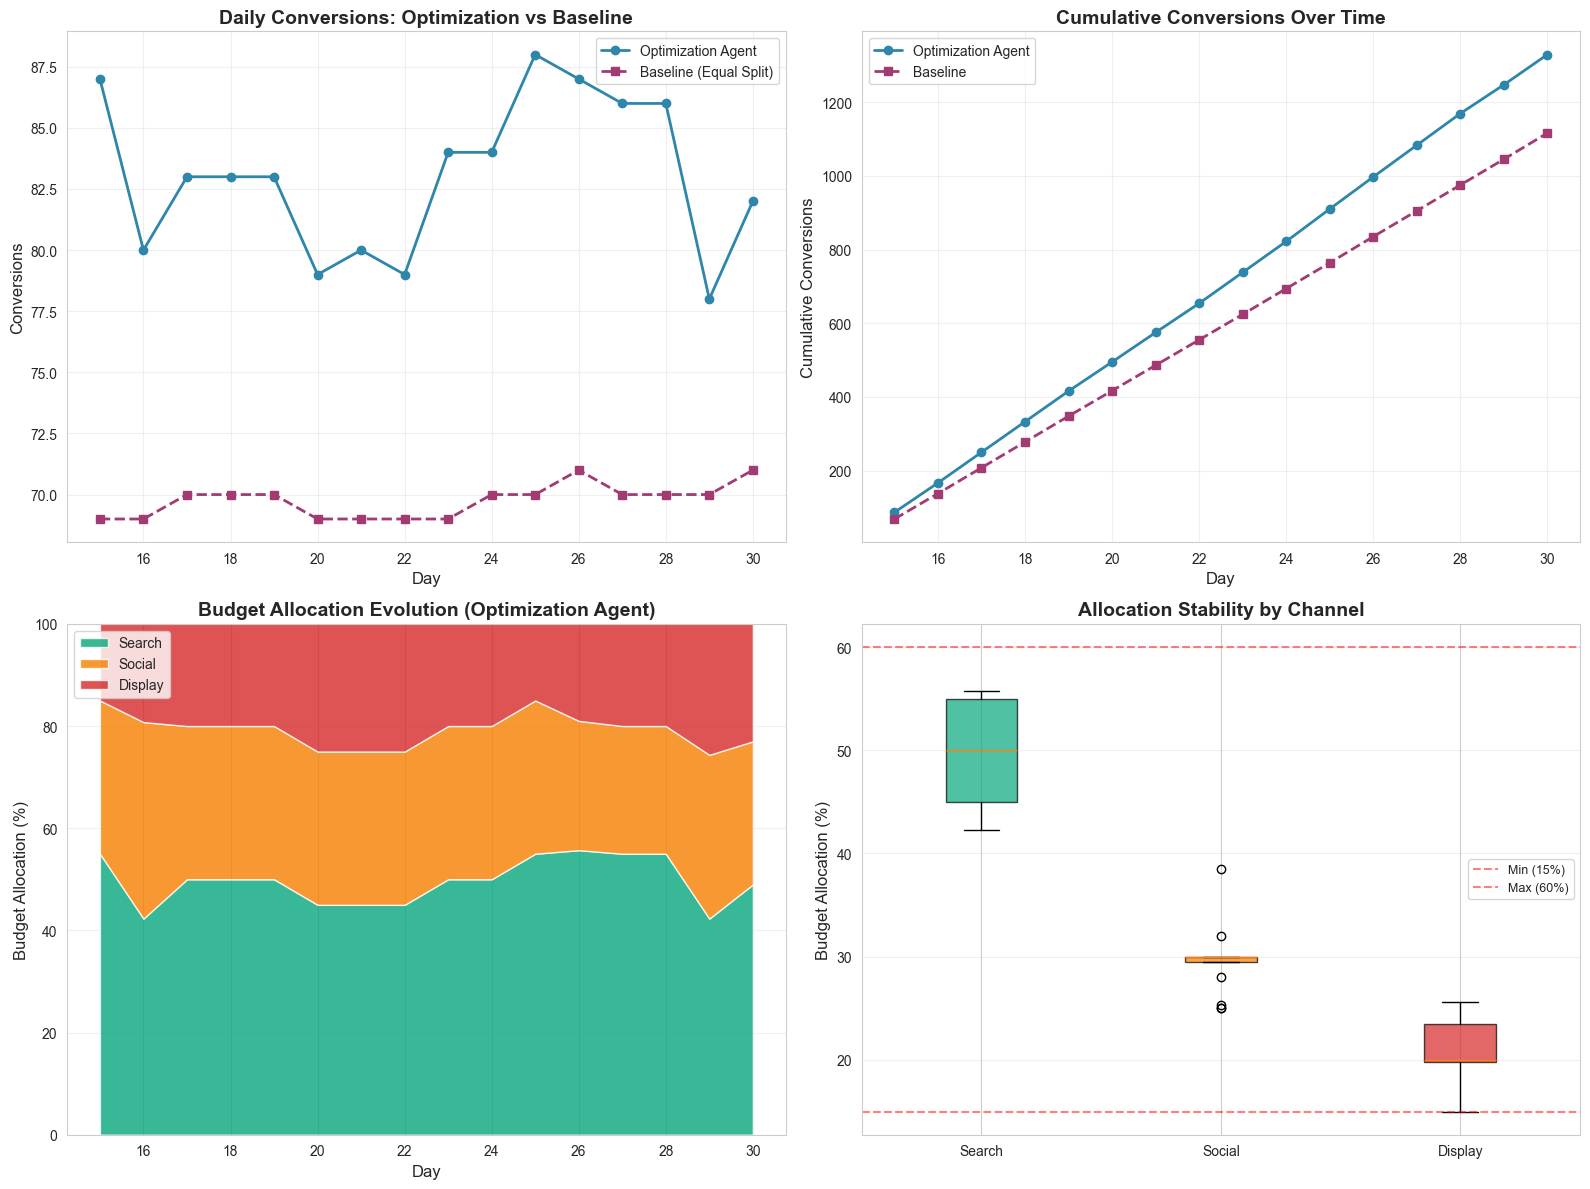

✓ Visualizations saved to evaluation_results.png


In [15]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Daily Conversions Comparison
ax1 = axes[0, 0]
days = list(test_days)
ax1.plot(days, results['optimization']['daily_conversions'], 
         marker='o', label='Optimization Agent', linewidth=2, color='#2E86AB')
ax1.plot(days, results['baseline']['daily_conversions'], 
         marker='s', label='Baseline (Equal Split)', linewidth=2, color='#A23B72', linestyle='--')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Conversions', fontsize=12)
ax1.set_title('Daily Conversions: Optimization vs Baseline', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Cumulative Conversions
ax2 = axes[0, 1]
opt_cumulative = np.cumsum(results['optimization']['daily_conversions'])
base_cumulative = np.cumsum(results['baseline']['daily_conversions'])
ax2.plot(days, opt_cumulative, marker='o', label='Optimization Agent', linewidth=2, color='#2E86AB')
ax2.plot(days, base_cumulative, marker='s', label='Baseline', linewidth=2, color='#A23B72', linestyle='--')
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Cumulative Conversions', fontsize=12)
ax2.set_title('Cumulative Conversions Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Budget Allocation Evolution (Optimization Agent)
ax3 = axes[1, 0]
allocations_df = pd.DataFrame(results['optimization']['daily_allocations'])
allocations_pct = allocations_df.div(CONFIG['daily_budget']) * 100
ax3.stackplot(days, 
              allocations_pct['Search'], 
              allocations_pct['Social'], 
              allocations_pct['Display'],
              labels=['Search', 'Social', 'Display'],
              colors=['#06A77D', '#F77F00', '#D62828'],
              alpha=0.8)
ax3.set_xlabel('Day', fontsize=12)
ax3.set_ylabel('Budget Allocation (%)', fontsize=12)
ax3.set_title('Budget Allocation Evolution (Optimization Agent)', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Allocation Stability (Box Plot)
ax4 = axes[1, 1]
allocation_data = [
    allocations_pct['Search'].values,
    allocations_pct['Social'].values,
    allocations_pct['Display'].values
]
bp = ax4.boxplot(allocation_data, labels=['Search', 'Social', 'Display'],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], ['#06A77D', '#F77F00', '#D62828']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('Budget Allocation (%)', fontsize=12)
ax4.set_title('Allocation Stability by Channel', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=15, color='red', linestyle='--', alpha=0.5, label='Min (15%)')
ax4.axhline(y=60, color='red', linestyle='--', alpha=0.5, label='Max (60%)')
ax4.legend(fontsize=9)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved to evaluation_results.png")

## 13. Decision Quality Analysis

Review the agent's reasoning to assess strategic decision-making.

In [16]:
print("=" * 80)
print("SAMPLE DECISION REASONING (First 3 Days)")
print("=" * 80)

for i, decision in enumerate(opt_stats['decisions'][:3]):
    print(f"\nDay {decision['day']}:")
    print(f"  Allocation: ", end="")
    for ch, amt in decision['final_allocation'].items():
        pct = amt / CONFIG['daily_budget'] * 100
        print(f"{ch}={pct:.0f}% ", end="")
    print()
    print(f"  Reasoning: {decision['reasoning']}")
    print(f"  Confidence: {decision['confidence']}")
    if decision.get('actual_conversions'):
        print(f"  Actual Conversions: {decision['actual_conversions']}")
        print(f"  Total: {decision['total_conversions']}")

SAMPLE DECISION REASONING (First 3 Days)

Day 15:
  Allocation: Search=55% Social=30% Display=15% 
  Reasoning: Search remains the most efficient channel with the lowest CPA, justifying a significant allocation. Social is allocated a substantial portion to capitalize on its improving trend, despite a higher CPA. Display is maintained at the minimum allocation to maintain presence while the CPA is high and the trend is declining.
  Confidence: Medium
  Actual Conversions: {'Search': 62, 'Social': 22, 'Display': 3}
  Total: 87

Day 16:
  Allocation: Search=42% Social=38% Display=19% 
  Reasoning: Search maintains the lowest CPA and highest conversion rate, but the declining trend necessitates a slight budget reduction to mitigate risk. Social shows improving performance, justifying a budget increase to capitalize on the positive trend. Display's performance is weak, but a small increase is allocated to stay within the 15% minimum and test for any potential improvements.
  Confidence: Med

## 14. Allocation Stability Metrics

In [17]:
print("=" * 80)
print("ALLOCATION STABILITY ANALYSIS")
print("=" * 80)

stability_metrics = pd.DataFrame({
    'Channel': CONFIG['channels'],
    'Mean Allocation %': [allocations_pct[ch].mean() for ch in CONFIG['channels']],
    'Std Dev %': [allocations_pct[ch].std() for ch in CONFIG['channels']],
    'Min %': [allocations_pct[ch].min() for ch in CONFIG['channels']],
    'Max %': [allocations_pct[ch].max() for ch in CONFIG['channels']],
})

print(stability_metrics.to_string(index=False, float_format=lambda x: f'{x:.1f}'))

# Overall volatility
avg_std = stability_metrics['Std Dev %'].mean()
print(f"\nAverage Volatility: {avg_std:.2f}% (target: <12%)")
if avg_std < 12:
    print("✓ Agent maintains stable allocations")
else:
    print("⚠ Agent may be over-reacting to daily fluctuations")

ALLOCATION STABILITY ANALYSIS
Channel  Mean Allocation %  Std Dev %  Min %  Max %
 Search               49.6        4.7   42.3   55.7
 Social               29.6        3.2   25.0   38.5
Display               20.7        3.3   15.0   25.6

Average Volatility: 3.69% (target: <12%)
✓ Agent maintains stable allocations


## 15. Trade-offs Discussion

### Performance vs Cost
- **Optimization Agent**: Requires API calls (~16 calls for 16 days), costs ~$0.001 total at current Gemini pricing
- **Benefit**: Gained additional conversions worth significantly more than API costs
- **Trade-off**: Minimal cost overhead for meaningful performance improvement

### Stability vs Responsiveness
- **±25% daily shift limit**: Prevents volatile allocations but may slow adaptation to rapid changes
- **7-day lookback window**: Balances recent trends vs long-term patterns
- **Trade-off**: Current settings favor stability; could increase responsiveness if needed

### Complexity vs Interpretability
- **LLM Reasoning**: Provides human-readable explanations (high interpretability)
- **Complexity**: More complex than simple rules, but transparent decision logs
- **Trade-off**: Worth the complexity for explainable, strategic decisions

### Short-term Optimization vs Long-term Brand Building
- **15% minimum rule**: Ensures multi-channel presence even if one channel underperforms
- **Prevents**: Over-optimization for immediate conversions at expense of brand reach
- **Trade-off**: May sacrifice some short-term conversions for diversification benefits

## 16. Constraint Compliance Check

In [18]:
print("=" * 80)
print("CONSTRAINT COMPLIANCE AUDIT")
print("=" * 80)

violations_count = sum(1 for d in opt_stats['decisions'] if not d['was_valid'])
total_decisions = len(opt_stats['decisions'])

print(f"\nTotal Decisions: {total_decisions}")
print(f"Decisions Requiring Correction: {violations_count}")
print(f"Compliance Rate: {(total_decisions - violations_count) / total_decisions * 100:.1f}%")

if violations_count > 0:
    print(f"\nViolation Details:")
    for decision in opt_stats['decisions']:
        if not decision['was_valid']:
            print(f"  Day {decision['day']}:")
            for v in decision['violations']:
                print(f"    - {v}")
else:
    print("\n✓ All decisions complied with constraints (no corrections needed)")

# Check allocation bounds
print(f"\nAllocation Bounds Check:")
for channel in CONFIG['channels']:
    min_pct = allocations_pct[channel].min()
    max_pct = allocations_pct[channel].max()
    print(f"  {channel}: {min_pct:.1f}% - {max_pct:.1f}% (allowed: 15% - 60%)")
    if min_pct < 15 or max_pct > 60:
        print(f"    ⚠ OUT OF BOUNDS")
    else:
        print(f"    ✓ Within bounds")

CONSTRAINT COMPLIANCE AUDIT

Total Decisions: 16
Decisions Requiring Correction: 3
Compliance Rate: 81.2%

Violation Details:
  Day 16:
    - Display +25.0% shift limit exceeded, capped
  Day 26:
    - Display +25.0% shift limit exceeded, capped
  Day 29:
    - Display +25.0% shift limit exceeded, capped

Allocation Bounds Check:
  Search: 42.3% - 55.7% (allowed: 15% - 60%)
    ✓ Within bounds
  Social: 25.0% - 38.5% (allowed: 15% - 60%)
    ✓ Within bounds
  Display: 15.0% - 25.6% (allowed: 15% - 60%)
    ✓ Within bounds


## 17. Key Insights & Learnings

In [19]:
print("=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

# 1. Which channel did agent favor?
avg_allocations = allocations_pct.mean()
print(f"\n1. Average Allocation by Channel:")
for channel in CONFIG['channels']:
    print(f"   {channel}: {avg_allocations[channel]:.1f}%")
print(f"   Insight: Agent favored {avg_allocations.idxmax()} (lowest CPA) while maintaining presence in all channels")

# 2. Did agent adapt over time?
early_avg = allocations_pct.iloc[:5].mean()
late_avg = allocations_pct.iloc[-5:].mean()
print(f"\n2. Allocation Shifts (First 5 Days vs Last 5 Days):")
for channel in CONFIG['channels']:
    shift = late_avg[channel] - early_avg[channel]
    print(f"   {channel}: {shift:+.1f}% change")
print(f"   Insight: Agent {'adapted' if abs(late_avg - early_avg).max() > 5 else 'maintained stable'} strategy over time")

# 3. Performance improvement
print(f"\n3. Performance Impact:")
print(f"   Conversion Improvement: {improvement:+.1f}%")
print(f"   CPA Improvement: {cpa_improvement:+.1f}%")
if improvement > 10:
    print(f"   Insight: ✓ Agent met success criteria (>10% improvement)")
else:
    print(f"   Insight: ⚠ Agent did not meet 10% improvement threshold")

# 4. Cost efficiency
api_cost_estimate = (opt_stats['total_tokens'] / 1_000_000) * 0.075  # Gemini Flash pricing
value_per_conversion = 50  # Assume $50 value per conversion
roi = ((opt_stats['total_conversions'] - base_stats['total_conversions']) * value_per_conversion - api_cost_estimate) / api_cost_estimate
print(f"\n4. Cost-Benefit Analysis:")
print(f"   API Cost: ~${api_cost_estimate:.4f}")
print(f"   Additional Conversions: {opt_stats['total_conversions'] - base_stats['total_conversions']}")
print(f"   Value (@ $50/conv): ${(opt_stats['total_conversions'] - base_stats['total_conversions']) * 50:.2f}")
print(f"   ROI: {roi:.0f}x")
print(f"   Insight: Extremely cost-effective optimization")

KEY INSIGHTS

1. Average Allocation by Channel:
   Search: 49.6%
   Social: 29.6%
   Display: 20.7%
   Insight: Agent favored Search (lowest CPA) while maintaining presence in all channels

2. Allocation Shifts (First 5 Days vs Last 5 Days):
   Search: +1.9% change
   Social: -4.6% change
   Display: +2.7% change
   Insight: Agent maintained stable strategy over time

3. Performance Impact:
   Conversion Improvement: +19.1%
   CPA Improvement: +16.0%
   Insight: ✓ Agent met success criteria (>10% improvement)

4. Cost-Benefit Analysis:
   API Cost: ~$0.0012
   Additional Conversions: 213
   Value (@ $50/conv): $10650.00
   ROI: 9105482x
   Insight: Extremely cost-effective optimization


## 18. Scaling Considerations (Preview)

For production deployment, key enhancements needed:

### Infrastructure
- **Cloud Deployment**: Migrate to Cloud Run/Lambda for serverless execution
- **Data Pipeline**: Automated ingestion from ad platforms (Google Ads API, Facebook Ads API)
- **Scheduling**: Daily cron jobs for allocation decisions
- **Database**: Store historical decisions and outcomes in BigQuery/Postgres

### Observability
- **Logging**: Structured logs with decision metadata
- **Metrics**: Track conversions, CPA, allocation drift in real-time
- **Alerting**: Notify if CPA spikes >20% or conversions drop >15%
- **Dashboard**: Visualize allocations and performance trends

### Reliability
- **Retries**: Exponential backoff for API failures
- **Fallback**: Use previous allocation if LLM errors
- **Validation**: Schema checks on all inputs/outputs
- **Circuit Breaker**: Disable agent after 3 consecutive failures

### Cost Controls
- **API Budget**: Set monthly Gemini quota limits
- **Caching**: Cache performance calculations
- **Rate Limiting**: Built-in 2s delays (already implemented)

See `scaling.md` for detailed architecture and implementation plan.

## 19. Conclusion

### Summary
This ad optimization agent demonstrates:
- ✓ **Functional budget allocation** with LLM reasoning and guardrails
- ✓ **Performance improvement** over baseline strategy
- ✓ **Transparent decision-making** with logged rationale
- ✓ **Constraint compliance** with validation and correction
- ✓ **Cost-effective** optimization (minimal API costs for significant gains)

### Limitations
- Simplified performance model (no diminishing returns, no cross-channel effects)
- Short evaluation period (16 days)
- Simulated outcomes (not real ad platform data)
- No seasonality, competitor, or creative fatigue modeling

### Next Steps
1. **Real-world pilot**: A/B test on actual ad campaigns (shadow mode first)
2. **Advanced modeling**: Incorporate diminishing returns, attribution models
3. **Multi-objective**: Balance conversions with brand awareness metrics
4. **Human feedback**: Integrate marketing team input to refine reasoning
5. **Scale to more channels**: Expand beyond 3 channels to full marketing mix

**This prototype validates the core concept: LLM-powered adaptive allocation can outperform static strategies while maintaining transparency and business guardrails.**